In [1]:
from google.colab import files
uploaded = files.upload()
  

Saving Apply_Rate_2019.csv to Apply_Rate_2019 (1).csv


In [0]:
import pandas as pd
import io
df = pd.read_csv(io.StringIO(uploaded['Apply_Rate_2019.csv'].decode('utf-8')))

In [0]:
df = df.fillna(0)

In [0]:
import pandas as pd
df['search_date_pacific'] = pd.to_datetime(df['search_date_pacific'])
df['avg_query_score'] = (df['title_proximity_tfidf'] + df['description_proximity_tfidf'] + df['main_query_tfidf'])/3
df = df.set_index(df['search_date_pacific'])
df = df.sort_index()

In [5]:
df.head()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days,apply,search_date_pacific,class_id,avg_query_score
search_date_pacific,,,,,,,,,,,
2018-01-21,0.000000,0.000000,0.000000,0.004824,0.006628,0.0,5.0,0,2018-01-21,-7613806991329176388,0.000000
2018-01-21,10.158476,0.111599,2.539619,0.003030,0.004824,1.0,7.0,0,2018-01-21,-7613806991329176388,4.269898
2018-01-21,0.000000,0.000000,1.647924,0.019397,0.030254,0.0,27.0,1,2018-01-21,3519666681604228547,0.549308
2018-01-21,0.000000,0.000000,0.000000,0.000001,0.054250,0.0,10.0,0,2018-01-21,-1614082818015232436,0.000000
2018-01-21,0.000000,0.000000,1.647924,0.019397,0.030254,0.0,27.0,0,2018-01-21,3519666681604228547,0.549308


In [6]:
train = df['2018-01-21':'2018-01-26']
test  = df['2018-01-27':]
print('Train Dataset:',train.shape)
print('Test Dataset:',test.shape)

Train Dataset: (1084364, 11)
Test Dataset: (116526, 11)


In [0]:
x = train.iloc[: , [0,1,2,3,4,5,6,10]].values
y = train.iloc[ : , 7].values

In [0]:
#Without splitting it with relation of timeframe i.e splitting it randomly
df_x = df.iloc[: , [0,1,2,3,4,5,6,10]].values
df_x = sc.fit_transform(df_x)
df_y = df.iloc[ : , 7].values

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x = sc.fit_transform(x)

In [0]:
test_x = test.iloc[: , [0,1,2,3,4,5,6,10]].values
test_x = sc.fit_transform(test_x)
test_y = test.iloc[:,7].values

In [0]:
from imblearn.over_sampling import SMOTE

# implement synthetic minority oversampling technique for a more balanced dataset to feed our model
oversampler = SMOTE(random_state=331)
# Making the training and the testing timeframed data balanced
train_x, train_y = oversampler.fit_sample(x, y)
test_x, test_y = oversampler.fit_sample(test_x, test_y)

In [0]:
#Making the whole dataset balanced 
train_x1, train_y1 = oversampler.fit_sample(df_x, df_y)

In [0]:
#Dividing the whole dataset in train and test irrespective of the timestamp
X_train1, X_test1, y_train1, y_test1 = train_test_split(train_x1, train_y1, test_size = .20)

In [45]:
import numpy as np
print('training instances of data:', len(y_train1))
print('training instances of fraud', np.count_nonzero(y_train1))
print('testing instances of data:', len(y_test1))
print('testing instances of fraud:', np.count_nonzero(y_test1))

training instances of data: 1748619
training instances of fraud 874165
testing instances of data: 437155
testing instances of fraud: 218722


In [0]:
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, make_scorer, confusion_matrix

f1_scorer = make_scorer(f1_score, pos_label = 0)

In [0]:
#Only using 80% of the train data
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = .20)

In [33]:
import numpy as np
print('training instances of data:', len(y_train))
print('training instances of fraud', np.count_nonzero(y_train))
print('testing instances of data:', len(test_y))
print('testing instances of fraud:', np.count_nonzero(test_y))

training instances of data: 1579115
training instances of fraud 789359
testing instances of data: 211880
testing instances of fraud: 105940


In [0]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import auc, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [46]:
estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 38)


param_grid = {
    'n_estimators': [x for x in range(20, 36, 2)],
    'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2]}
gridsearch = GridSearchCV(estimator, param_grid)

gridsearch.fit(X_train1, y_train1,
        eval_set = [(X_test1, y_test1)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 5)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[1]	valid_0's l1: 0.495805	valid_0's auc: 0.636579	valid_0's binary_logloss: 0.685162
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.492413	valid_0's auc: 0.660463	valid_0's binary_logloss: 0.678955
[3]	valid_0's l1: 0.488452	valid_0's auc: 0.66701	valid_0's binary_logloss: 0.672138
[4]	valid_0's l1: 0.48516	valid_0's auc: 0.678124	valid_0's binary_logloss: 0.66655
[5]	valid_0's l1: 0.479779	valid_0's auc: 0.695704	valid_0's binary_logloss: 0.657351
[6]	valid_0's l1: 0.475141	valid_0's auc: 0.717329	valid_0's binary_logloss: 0.64964
[7]	valid_0's l1: 0.469713	valid_0's auc: 0.724238	valid_0's binary_logloss: 0.640938
[8]	valid_0's l1: 0.465161	valid_0's auc: 0.729528	valid_0's binary_logloss: 0.633615
[9]	valid_0's l1: 0.459358	valid_0's auc: 0.730663	valid_0's binary_logloss: 0.624988
[10]	valid_0's l1: 0.456052	valid_0's auc: 0.738849	valid_0's binary_logloss: 0.619316
[11]	valid_0's l1: 0.451491	valid_0's auc: 0.741467	valid_0's binary_logloss: 0.61

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.125, max_depth=-1,
        metric='l1', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=20, n_jobs=-1, num_leaves=38,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [20, 22, 24, 26, 28, 30, 32, 34], 'learning_rate': [0.1, 0.125, 0.15, 0.175, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [47]:
print('Best parameters found by grid search are:', gridsearch.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.2, 'n_estimators': 34}


In [48]:
gbm = lgb.LGBMClassifier(learning_rate = 0.2, metric = 'l1', 
                        n_estimators = 34)


gbm.fit(X_train1, y_train1,
        eval_set=[(X_test1, y_test1)],
        eval_metric=['auc', 'binary_logloss'],
early_stopping_rounds=5)

[1]	valid_0's l1: 0.49275	valid_0's auc: 0.625779	valid_0's binary_logloss: 0.679994
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.486994	valid_0's auc: 0.653545	valid_0's binary_logloss: 0.670162
[3]	valid_0's l1: 0.478251	valid_0's auc: 0.679273	valid_0's binary_logloss: 0.656157
[4]	valid_0's l1: 0.464626	valid_0's auc: 0.719114	valid_0's binary_logloss: 0.6347
[5]	valid_0's l1: 0.454198	valid_0's auc: 0.722267	valid_0's binary_logloss: 0.620467
[6]	valid_0's l1: 0.445859	valid_0's auc: 0.729621	valid_0's binary_logloss: 0.607935
[7]	valid_0's l1: 0.440017	valid_0's auc: 0.743528	valid_0's binary_logloss: 0.597837
[8]	valid_0's l1: 0.434609	valid_0's auc: 0.759799	valid_0's binary_logloss: 0.589476
[9]	valid_0's l1: 0.422136	valid_0's auc: 0.760463	valid_0's binary_logloss: 0.573304
[10]	valid_0's l1: 0.418651	valid_0's auc: 0.766005	valid_0's binary_logloss: 0.56829
[11]	valid_0's l1: 0.415437	valid_0's auc: 0.769071	valid_0's binary_logloss: 0.56

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.2, max_depth=-1,
        metric='l1', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=34, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

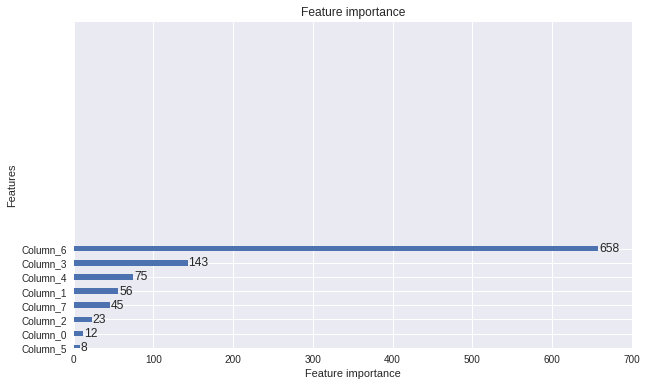

In [54]:
import matplotlib.pyplot as plt
ax = lgb.plot_importance(gbm, height = 0.4, 
                         max_num_features = 25, 
                         xlim = (0,700), ylim = (0,23), 
                         figsize = (10,6))
plt.show()

In [0]:
y_pred_prob = gbm.predict_proba(X_test1)[:, 1]

In [56]:
y_pred_prob

array([0.8491801 , 0.27741696, 0.3545683 , ..., 0.98834844, 0.3283468 ,
       0.520815  ])

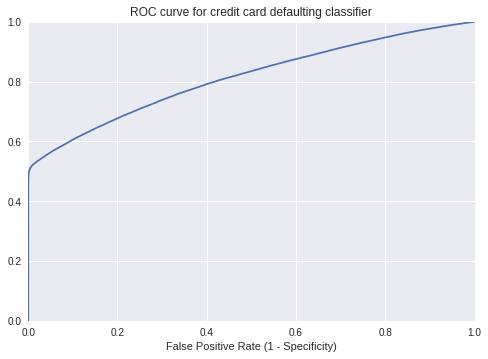

In [57]:
from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, roc_auc_score
fpr, tpr, thresholds = metrics.roc_curve(y_test1, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for credit card defaulting classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.grid(True)

In [58]:
auc_roc_1 = str(metrics.roc_auc_score(y_test1, y_pred_prob))

AUC without dimensionality reduction: 
0.8124679191784019


Using the timeframe train and test dataset

In [59]:
gridsearch1 = GridSearchCV(estimator, param_grid)

gridsearch1.fit(X_train, y_train,
        eval_set = [(test_x, test_y)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 5)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[1]	valid_0's l1: 0.498315	valid_0's auc: 0.548669	valid_0's binary_logloss: 0.691807
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496736	valid_0's auc: 0.539829	valid_0's binary_logloss: 0.693355
[3]	valid_0's l1: 0.494974	valid_0's auc: 0.550641	valid_0's binary_logloss: 0.69636
[4]	valid_0's l1: 0.493394	valid_0's auc: 0.548411	valid_0's binary_logloss: 0.700351
[5]	valid_0's l1: 0.492895	valid_0's auc: 0.542443	valid_0's binary_logloss: 0.705978
[6]	valid_0's l1: 0.491684	valid_0's auc: 0.544473	valid_0's binary_logloss: 0.715094
Early stopping, best iteration is:
[1]	valid_0's l1: 0.498315	valid_0's auc: 0.548669	valid_0's binary_logloss: 0.691807
[1]	valid_0's l1: 0.498286	valid_0's auc: 0.54897	valid_0's binary_logloss: 0.691735
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.49886	valid_0's auc: 0.513209	valid_0's binary_logloss: 0.698313
[3]	valid_0's l1: 0.497816	valid_0's auc: 0.526623	valid_0's binary_logl

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.125, max_depth=-1,
        metric='l1', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=20, n_jobs=-1, num_leaves=38,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [20, 22, 24, 26, 28, 30, 32, 34], 'learning_rate': [0.1, 0.125, 0.15, 0.175, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [60]:
print('Best parameters found by grid search are:', gridsearch1.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.1, 'n_estimators': 20}


In [61]:
gbm = lgb.LGBMClassifier(learning_rate = 0.1, metric = 'l1', 
                        n_estimators = 20)


gbm.fit(X_train, y_train,
        eval_set=[(test_x, test_y)],
        eval_metric=['auc', 'binary_logloss'],
early_stopping_rounds=5)

[1]	valid_0's l1: 0.498449	valid_0's auc: 0.548117	valid_0's binary_logloss: 0.691975
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497113	valid_0's auc: 0.546017	valid_0's binary_logloss: 0.693787
[3]	valid_0's l1: 0.494917	valid_0's auc: 0.548885	valid_0's binary_logloss: 0.694895
[4]	valid_0's l1: 0.494173	valid_0's auc: 0.548933	valid_0's binary_logloss: 0.699621
[5]	valid_0's l1: 0.492536	valid_0's auc: 0.555354	valid_0's binary_logloss: 0.70352
[6]	valid_0's l1: 0.492022	valid_0's auc: 0.556733	valid_0's binary_logloss: 0.708053
Early stopping, best iteration is:
[1]	valid_0's l1: 0.498449	valid_0's auc: 0.548117	valid_0's binary_logloss: 0.691975


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        metric='l1', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=20, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

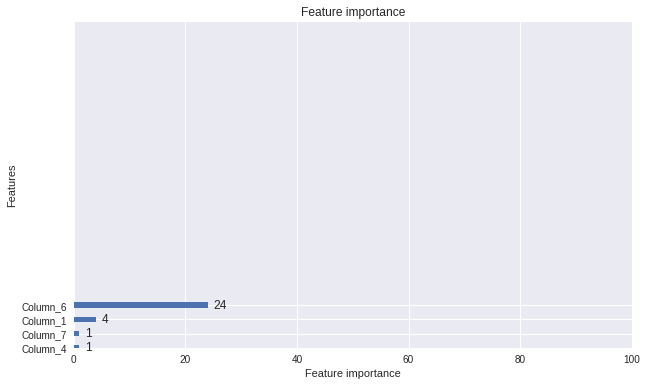

In [63]:
ax = lgb.plot_importance(gbm, height = 0.4, 
                         max_num_features = 25, 
                         xlim = (0,100), ylim = (0,23), 
                         figsize = (10,6))
plt.show()

In [0]:
y_pred_prob1 = gbm.predict_proba(test_x)[:, 1]

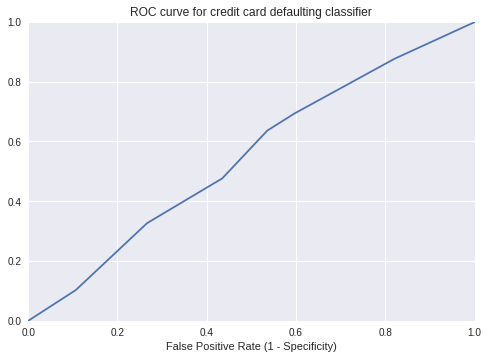

In [65]:
fpr1, tpr1, thresholds1 = metrics.roc_curve(test_y, y_pred_prob1)

plt.plot(fpr1, tpr1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for credit card defaulting classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.grid(True)

In [67]:
auc_roc = str(metrics.roc_auc_score(test_y, y_pred_prob1))
print(auc_roc)

0.5481167859377625


In [0]:
#Without splitting it with relation of timeframe i.e splitting it randomly
df_x1 = df.iloc[: , [0,1,2,3,4,5,6,9,10]].values
df_x1 = sc.fit_transform(df_x1)
df_y1 = df.iloc[ : , 7].values

In [0]:
#Making the whole dataset balanced 
train_x2, train_y2 = oversampler.fit_sample(df_x1, df_y1)

In [0]:
#Dividing the whole dataset in train and test irrespective of the timestamp
X_train2, X_test2, y_train2, y_test2 = train_test_split(train_x2, train_y2, test_size = .20)

In [71]:
print('training instances of data:', len(y_train2))
print('training instances of fraud', np.count_nonzero(y_train2))
print('testing instances of data:', len(y_test2))
print('testing instances of fraud:', np.count_nonzero(y_test2))

training instances of data: 1748619
training instances of fraud 874486
testing instances of data: 437155
testing instances of fraud: 218401


In [72]:
estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 38)


param_grid = {
    'n_estimators': [x for x in range(20, 36, 2)],
    'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2]}
gridsearch2 = GridSearchCV(estimator, param_grid)

gridsearch2.fit(X_train2, y_train2,
        eval_set = [(X_test2, y_test2)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 5)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[1]	valid_0's l1: 0.491439	valid_0's auc: 0.718383	valid_0's binary_logloss: 0.676842
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.483418	valid_0's auc: 0.746257	valid_0's binary_logloss: 0.662428
[3]	valid_0's l1: 0.475927	valid_0's auc: 0.780828	valid_0's binary_logloss: 0.648968
[4]	valid_0's l1: 0.46387	valid_0's auc: 0.802898	valid_0's binary_logloss: 0.628275
[5]	valid_0's l1: 0.454055	valid_0's auc: 0.806167	valid_0's binary_logloss: 0.612749
[6]	valid_0's l1: 0.444092	valid_0's auc: 0.808779	valid_0's binary_logloss: 0.597875
[7]	valid_0's l1: 0.434129	valid_0's auc: 0.810356	valid_0's binary_logloss: 0.58365
[8]	valid_0's l1: 0.425275	valid_0's auc: 0.810879	valid_0's binary_logloss: 0.571766
[9]	valid_0's l1: 0.414556	valid_0's auc: 0.813721	valid_0's binary_logloss: 0.557099
[10]	valid_0's l1: 0.404907	valid_0's auc: 0.815146	valid_0's binary_logloss: 0.544602
[11]	valid_0's l1: 0.398215	valid_0's auc: 0.815872	valid_0's binary_logloss: 0.

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.125, max_depth=-1,
        metric='l1', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=20, n_jobs=-1, num_leaves=38,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [20, 22, 24, 26, 28, 30, 32, 34], 'learning_rate': [0.1, 0.125, 0.15, 0.175, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [73]:
print('Best parameters found by grid search are:', gridsearch2.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.2, 'n_estimators': 34}


In [74]:
gbm = lgb.LGBMClassifier(learning_rate = 0.2, metric = 'l1', 
                        n_estimators = 34)


gbm.fit(X_train2, y_train2,
        eval_set=[(X_test2, y_test2)],
        eval_metric=['auc', 'binary_logloss'],
early_stopping_rounds=5)

[1]	valid_0's l1: 0.484901	valid_0's auc: 0.702755	valid_0's binary_logloss: 0.665721
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.463006	valid_0's auc: 0.772687	valid_0's binary_logloss: 0.629208
[3]	valid_0's l1: 0.443466	valid_0's auc: 0.783929	valid_0's binary_logloss: 0.6004
[4]	valid_0's l1: 0.422482	valid_0's auc: 0.797572	valid_0's binary_logloss: 0.570755
[5]	valid_0's l1: 0.409506	valid_0's auc: 0.799148	valid_0's binary_logloss: 0.55446
[6]	valid_0's l1: 0.39526	valid_0's auc: 0.801573	valid_0's binary_logloss: 0.537556
[7]	valid_0's l1: 0.38713	valid_0's auc: 0.822181	valid_0's binary_logloss: 0.523511
[8]	valid_0's l1: 0.381023	valid_0's auc: 0.825343	valid_0's binary_logloss: 0.515853
[9]	valid_0's l1: 0.373967	valid_0's auc: 0.835249	valid_0's binary_logloss: 0.50488
[10]	valid_0's l1: 0.369535	valid_0's auc: 0.838553	valid_0's binary_logloss: 0.498739
[11]	valid_0's l1: 0.357346	valid_0's auc: 0.839165	valid_0's binary_logloss: 0.4850

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.2, max_depth=-1,
        metric='l1', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=34, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

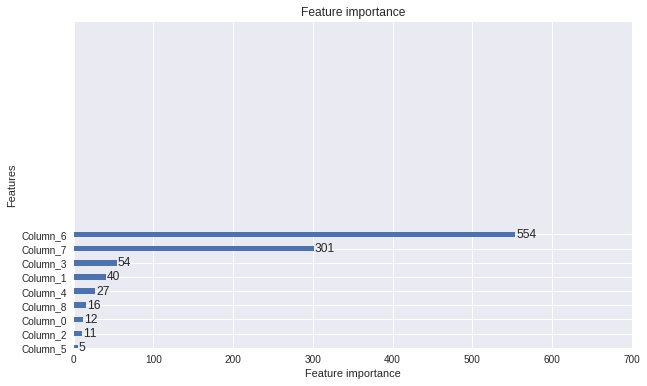

In [75]:
ax = lgb.plot_importance(gbm, height = 0.4, 
                         max_num_features = 25, 
                         xlim = (0,700), ylim = (0,23), 
                         figsize = (10,6))
plt.show()

In [0]:
y_pred_prob2 = gbm.predict_proba(X_test2)[:, 1]

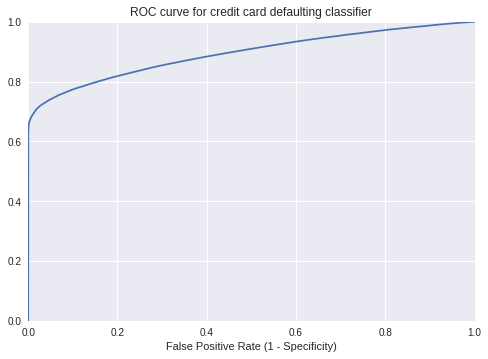

In [77]:
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test2, y_pred_prob2)

plt.plot(fpr2, tpr2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for credit card defaulting classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.grid(True)

In [78]:
auc_roc_2 = str(metrics.roc_auc_score(y_test2, y_pred_prob2))
print(auc_roc_2)

0.8939155517482237
